# Applying MeTA classification model 

In this notebook, we walk you through using the random forest trained on IGPS and PTP1B to make predictions on your unlabeled data.

In [20]:
#standard 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

#model to use
from sklearn.ensemble import RandomForestClassifier

#model performance
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time
#for easy visualization of model performance
import scikitplot as skplt

#importing model
import pickle 

#custom function for trim mean and std deviation
def trim_mean_std(data, frac=0.05):    
    mean = stats.trim_mean(data, frac)
    std = stats.tstd(data, limits=(frac * np.max(data), (1 - frac) * np.max(data)))
    return mean, std

#Dictionary to convert amino acid abreviations
aa_dict = {'ALA': 'A', 'CYS':'C', 'ASP': 'D', 'GLU':'E',
          'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
          'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
          'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T',
          'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

#Dictionary to bucket amino acids
condensed_dict = {'L': 'LAIVMH', 'A': 'LAIVMH', 'I': 'LAIVMH', 'V': 'LAIVMH', 'M': 'LAIVMH', 'H': 'LAIVMH',
                  'D': 'DEQ', 'E': 'DEQ', 'Q': 'DEQ', 
                  'S': 'STGRFN', 'T': 'STGRFN', 'G': 'STGRFN', 'R': 'STGRFN', 'F': 'STGRFN', 'N': 'STGRFN',
                  'K': 'K'}

## Importing data

In the cell below, please write the name of the csv containing your data. Look at the structure of the file 'IGPS_unlabeled.csv' to see how you should structure your data. Make sure this notebook and the file are in the same directory.

In [21]:
### INSERT YOUR DATA PATH HERE ####
your_data_filename = 'data/IGPS_unlabeled.csv'
### INSERT YOUR DATA PATH HERE ####

your_unlabeled_data = pd.read_csv(your_data_filename).dropna(axis=0)

your_unlabeled_data.columns = ['0%', '1%', '5%', '10%'] 
print(your_unlabeled_data.head())
print(your_unlabeled_data.shape)

        0%           1%           5%          10%
0  70817.0  48836.26190  35416.90963  13722.06797
1  56457.0  41255.86774  34030.53055  14549.18591
2  84293.0  70637.32580  51737.79568  24447.40255
3  37792.0  27637.72522  20032.70190  12014.13218
4  87872.0  68161.90034  47255.06422  34808.69365
(126, 4)


If the cell above ran and looks right (higher signals in the right column, lower in the left) and has the right number of observations, just execute all of the following cells.

In [22]:
#feature engineering
div_by_zero = your_unlabeled_data[['1%', '5%', '10%']].values / your_unlabeled_data[['0%']].values 
div_by_one = your_unlabeled_data[['5%', '10%']].values / your_unlabeled_data[['1%']].values
div_by_five = your_unlabeled_data[['10%']].values / your_unlabeled_data[['5%']].values
ratio_cols = ['1/0', '5/0', '10/0', '5/1', '10/1', '10/5']
ratios = np.concatenate((div_by_zero, div_by_one, div_by_five), axis=1)
ratios_df = pd.DataFrame(ratios, columns=ratio_cols)

In [23]:
#normal z score function
def z_score(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    zeroed_data = np.subtract(data, means)
    scaled_data = np.divide(zeroed_data, stds)
    return scaled_data 

#trim z score function
def trim_log_z_score(data, frac=0.05):
    '''
    Args:
    data (NUMPY ARRAY!!): numpy array of data to be log transformed and scaled, not robust to negative numbers
    frac (float): how much to trim mean and standard deviation
    Returns:
    scaled_data (numpy array): log transformed and scaled data
    '''
    log_data = np.log(np.clip(data, 0.1, None))
    trim_means_and_std = np.apply_along_axis(func1d=trim_mean_std, axis=0, arr=log_data, frac=frac)
    means = trim_means_and_std[0,:].reshape(1,-1)
    stds = trim_means_and_std[1,:].reshape(1,-1)
    zeroed_data = np.subtract(log_data, means)
    scaled_data = np.divide(zeroed_data, stds)
    return scaled_data

In [24]:
#ratio z scores
z_ratio = z_score(ratios_df.values)

#signal log z scores
z_signal = trim_log_z_score(your_unlabeled_data.values, frac=0.05)

#model_input
input_data = np.concatenate((z_signal, z_ratio), axis=1)

#loading model
filename = 'model/IGPS_PTP1B_model.sav'
loaded_forest = pickle.load(open(filename, 'rb'))

#making predictions
preds = loaded_forest.predict(input_data)
preds_bucket = [condensed_dict[i] for i in preds]

#output data
your_unlabeled_data['bucket'] = preds_bucket
your_unlabeled_data.to_csv('output_data/unlabeled_output.csv')
your_unlabeled_data.head()

,0%,1%,5%,10%,bucket
0,70817.0,48836.26190,35416.90963,13722.06797,LAIVMH
1,56457.0,41255.86774,34030.53055,14549.18591,LAIVMH
2,84293.0,70637.32580,51737.79568,24447.40255,LAIVMH
3,37792.0,27637.72522,20032.70190,12014.13218,STGRFN
4,87872.0,68161.90034,47255.06422,34808.69365,STGRFN


Your data has now been saved as 'unlabeled_output.csv'.

## Optional extra inquery

If you're curious about how the model is making predictions on specific amino acids in your protein, you can execute the following cell.

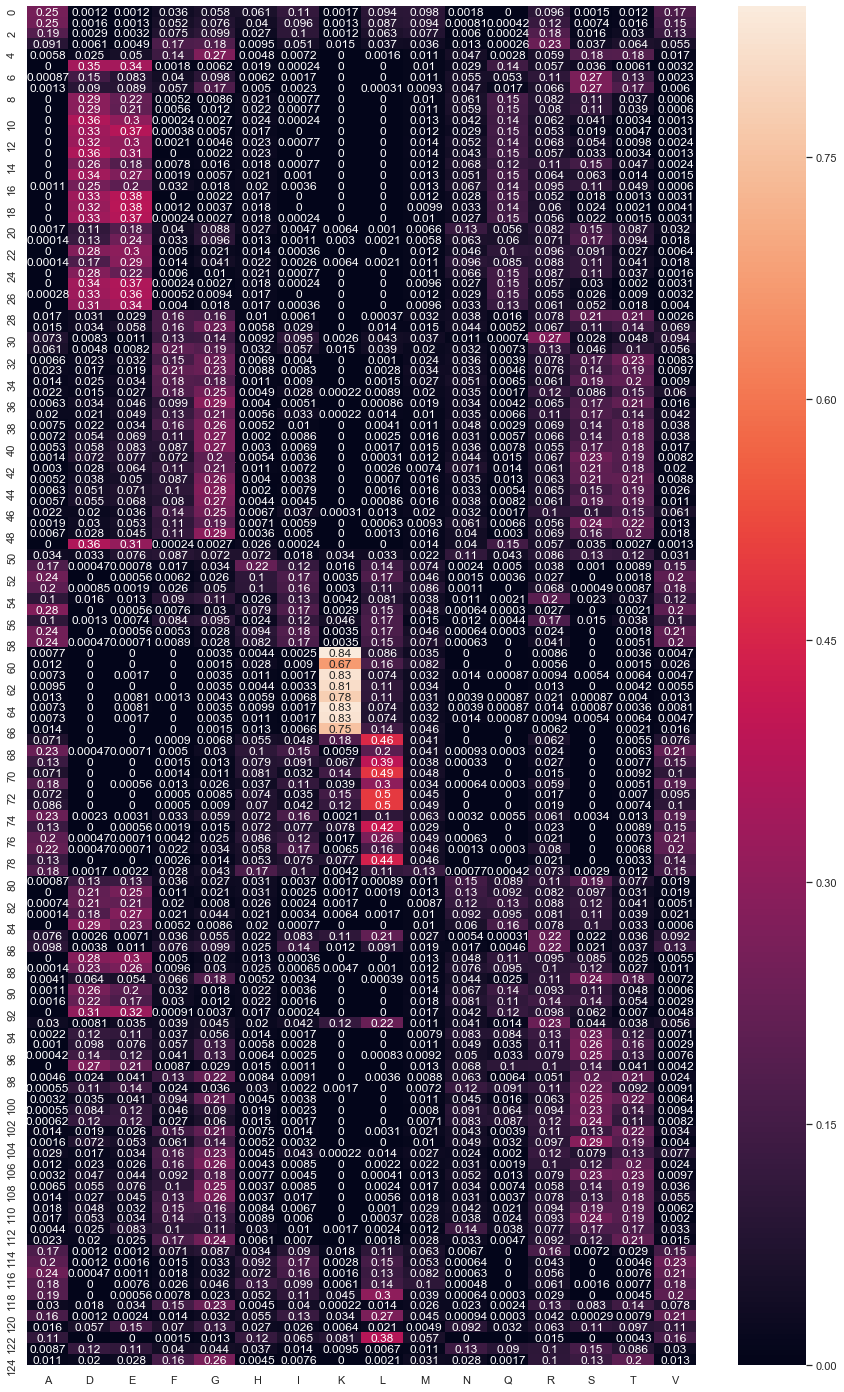

In [25]:
labels = ['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'Q', 'R', 'S', 'T', 'V']
sns.set(rc={'figure.figsize':(15,25)})
preds_proba = loaded_forest.predict_proba(input_data)
labels.sort()
preds_proba_df = pd.DataFrame(preds_proba, columns=labels)
preds_probab_df = preds_proba_df.sort_index(inplace=True)
ax = sns.heatmap(preds_proba_df, annot=True)
ax.set_ylim(125,0)
plt.show()